In [27]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv('ToyotaCorolla_modificado - ToyotaCorolla_modificado.csv')

In [4]:
sns.set(rc = {'figure.figsize':(15,8)})

<AxesSubplot:xlabel='Weight', ylabel='Price'>

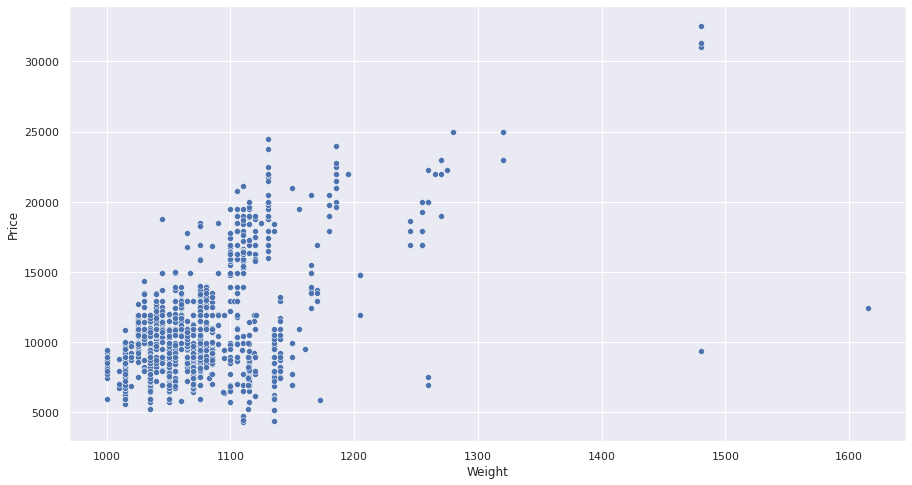

In [5]:
sns.scatterplot(x=df.Weight, y=df.Price)

<AxesSubplot:xlabel='KM', ylabel='Price'>

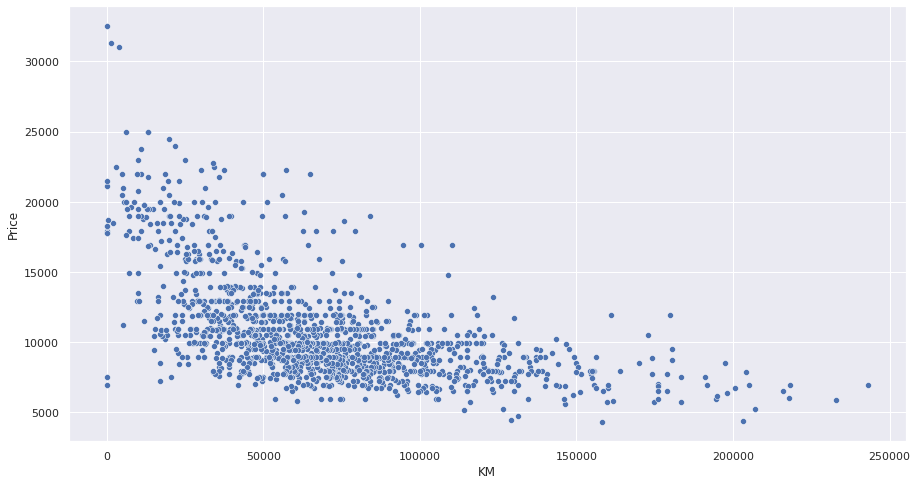

In [6]:
sns.scatterplot(x=df.KM, y=df.Price)

In [9]:
df.shape

(1436, 37)

In [31]:
#OUTLIERS
Q1 = df.Price.quantile(0.25)
Q3 = df.Price.quantile(0.75)
IQR = Q3 - Q1
BI = Q1 - 1.5*IQR
BS = Q3 + 1.5*IQR
out = ((df.Price < BI) | (df.Price > BS))
out.sum()

110

In [35]:
100*out.sum()/out.count()

7.66016713091922

In [37]:
#OUTLIERS APLICANDO LOG
price_log = np.log(df.Price)
Q1 = price_log.quantile(0.25)
Q3 = price_log.quantile(0.75)
IQR = Q3 - Q1
BI = Q1 - 1.5*IQR
BS = Q3 + 1.5*IQR
out = ((price_log < BI) | (price_log > BS))
out.sum()

41

In [38]:
100*out.sum()/out.count()

2.8551532033426184

In [28]:
def graficar_info_variable(variable, b=8):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.histplot(data=variable, bins=b ,ax=axes[0])
    sns.boxplot(data=variable, ax=axes[1])
    sns.violinplot(data=variable, ax=axes[2])

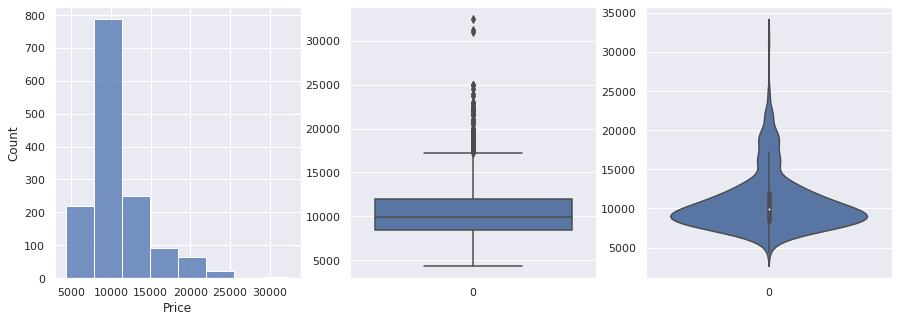

In [29]:
graficar_info_variable(df.Price)

In [34]:
df2 = df.Price > 15000
df2.sum()

168